In [1]:
import os
import numpy as np
from astropy.table import Table, vstack

In [2]:
from desiutil.log import get_logger
log = get_logger()

In [3]:
#import tempfile
#os.environ['MPLCONFIGDIR'] = tempfile.mkdtemp()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.3)#, rc=rc)

%matplotlib inline

In [4]:
%env DESI_ROOT=/global/cfs/cdirs/desi
%env NYXGALAXY_DATA=/global/cfs/cdirs/desi/users/ioannis/nyxgalaxy

env: DESI_ROOT=/global/cfs/cdirs/desi
env: NYXGALAXY_DATA=/global/cfs/cdirs/desi/users/ioannis/nyxgalaxy


In [5]:
nyxgalaxy_dir = os.getenv('NYXGALAXY_DATA')
analysisdir = os.path.join(nyxgalaxy_dir, 'analysis')
if not os.path.isdir(analysisdir):
    os.makedirs(analysisdir)

In [6]:
def read_results(tilenight):
    nyxgalaxyfile = os.path.join(nyxgalaxy_dir, 'results', 
                                 'nyxgalaxy-{}.fits'.format(tilenight))
    if not os.path.isfile(nyxgalaxyfile):
        log.info('Output file {} not found!'.format(nyxgalaxyfile))
        return
    nyxgalaxy = Table.read(nyxgalaxyfile)
    return nyxgalaxy

In [59]:
#'70500-20200303'

tiletarg = {
    '67230-20200315': 'ELG',
    '67142-20200315': 'ELG',
    '68001-20200315': 'LRG',
    '68002-20200315': 'LRG',
    '66003-20200315': 'BGS',
}

res = []
for tilenight in tiletarg.keys():
    res.append(read_results(tilenight=tilenight))
res = vstack(res)
res = res[res['CONTINUUM_CHI2'] > 0]
ngal = len(res)
print(ngal)

10078


In [78]:
def zhist():
    tilenight = np.array(['{}-{}'.format(tile, night) for tile, night in zip(res['TILE'], res['NIGHT'])])

    indx = {'ELG': np.array([], np.int), 'BGS': np.array([], np.int), 'LRG': np.array([], np.int)}
    for tile in set(tilenight):
        targ = tiletarg[tile]
        these = np.where(tile == tilenight)[0]
        indx[targ] = np.hstack((indx[targ], these))

    fig, ax = plt.subplots(figsize=(10, 7))
    for targ in sorted(indx.keys()):
        these = indx[targ]
        print(targ, len(these))
        _ = ax.hist(res['Z'][these], label='{} (N={})'.format(targ, len(these)), 
                    range=(-0.05, 1.7), bins=100, alpha=0.7)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    
    ax.legend(fontsize=18)
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Number of Galaxies')
    
    pngfile = os.path.join(analysisdir, 'zhist.png')
    print('Writing {}'.format(pngfile))
    fig.savefig(pngfile)

BGS 2202
ELG 4438
LRG 3438
Writing /global/cfs/cdirs/desi/users/ioannis/nyxgalaxy/analysis/zhist.png


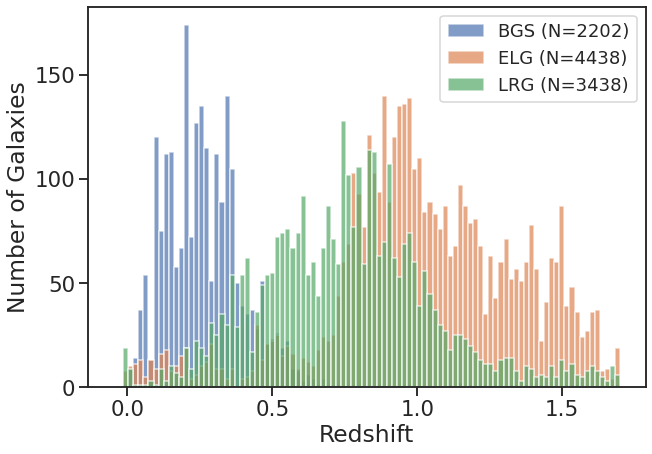

In [79]:
zhist()

(0.0, 10.0)

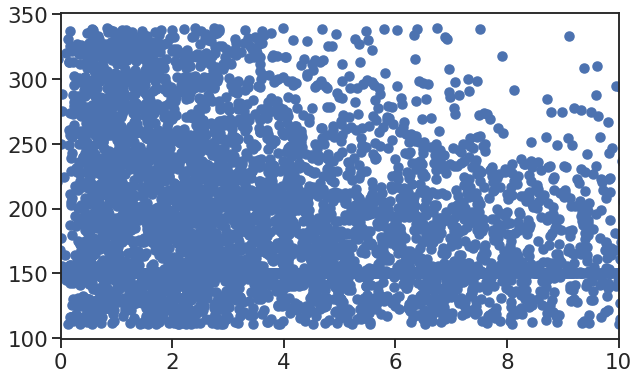

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(res['CONTINUUM_SNR'][:, 2], res['CONTINUUM_VDISP'])
#ax.set_xscale('log')
ax.set_xlim(0, 10)

In [57]:
def oplot_class(ax, kewley=False, **kwargs):
    if kewley:
        niiha = np.linspace(-1.9, 0.4, 1000)
        oiiihb = 0.61 / (niiha-0.47) + 1.19
    else:
        niiha = np.linspace(-1.9, -0.1, 1000)
        oiiihb = 0.61 / (niiha-0.05) + 1.3
        
    ax.plot(niiha, oiiihb, **kwargs)

def bpt():
    good = np.where(
        (res['HALPHA_FLUX'] > 0) * 
        (res['HBETA_FLUX'] > 0) * 
        (res['NII_6584_FLUX'] > 0) * 
        (res['OIII_5007_FLUX'] > 0) *
        (res['HALPHA_CHI2'] < 1e4)
    )[0]
    
    zz = res['Z'][good]
    niiha = np.log10(res['NII_6584_FLUX'][good] / res['HALPHA_FLUX'][good])
    oiiihb = np.log10(res['OIII_5007_FLUX'][good] / res['HBETA_FLUX'][good])
    ww = np.where((niiha > -0.05) * (niiha < 0.05) * (oiiihb < -0.5))[0]
    #print(res[good][ww]['HALPHA_FLUX', 'NII_6584_FLUX'])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    #for tile in set(res['TILE'][good]):
    #    ax.scatter(niiha, oiiihb, label='{}'.format(tile), alpha=0.8, s=20)
    cb = ax.scatter(niiha, oiiihb, c=zz, cmap='viridis', vmin=0.0, vmax=0.5)
    oplot_class(ax, kewley=True, color='red', ls='--', lw=3,
                label='Kewley+01')
    oplot_class(ax, kewley=False, color='k', lw=3,
                label='Kauffmann+03')
    plt.colorbar(cb, label='Redshift')
    
    ax.set_xlim(-1.9, 0.7)
    ax.set_ylim(-1.2, 1.5)
    ax.set_xlabel(r'$\log_{10}$ ([NII] $\lambda6584$ / H$\alpha$)')
    ax.set_ylabel(r'$\log_{10}$ ([OIII] $\lambda5007$ / H$\beta$)')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    
    ax.legend(fontsize=16, loc='lower left')#, ncol=2)

    plt.subplots_adjust(bottom=0.15, left=0.18, top=0.95, right=0.95)
    
    fig.savefig(os.path.join(analysisdir, 'bpt.png'))    

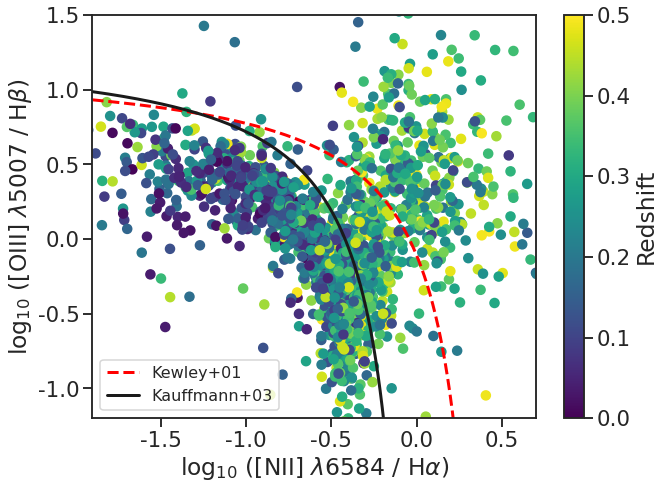

In [58]:
bpt()

In [11]:
def d4000_ewhb():
    good = np.where((res['D4000_IVAR'] > 0) * (res['HBETA_EW'] > 0))[0]
    
    d4000 = res['D4000_MODEL'][good].data
    ewhb = np.log10(res['HBETA_EW'][good].data)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(d4000, ewhb, s=30)
    
    ax.set_xlim(0.75, 2.0)
    ax.set_ylim(-2, 3.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.set_xlabel(r'$D_{n}(4000)$')
    ax.set_ylabel(r'$\log_{10}$ EW(H$\beta)$')
    #ax.legend(fontsize=18, loc='upper left')

    plt.subplots_adjust(bottom=0.15, left=0.18, top=0.95, right=0.95)
    
    fig.savefig(os.path.join(analysisdir, 'bpt.png'))    

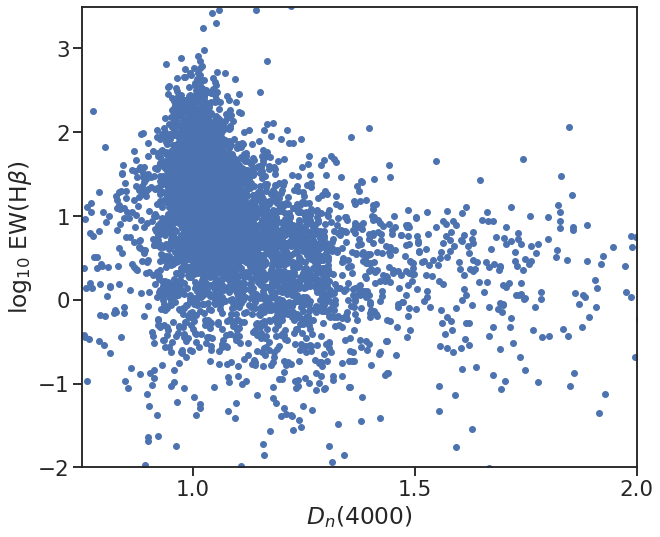

In [12]:
d4000_ewhb()

In [14]:
res.info()

<Table length=10078>
           name            dtype  shape              unit             n_bad
------------------------- ------- ----- ----------------------------- -----
                     TILE  bytes5                                         0
                    NIGHT  bytes8                                         0
                 TARGETID   int64                                         0
                        Z float64                                         0
                    FIBER   int32                                         0
            CONTINUUM_SNR float32  (3,)                                   0
              CONTINUUM_Z float64                                         0
          CONTINUUM_COEFF float64 (38,)                                   0
           CONTINUUM_CHI2 float32                                         0
            CONTINUUM_AGE float32                                 Gyr     0
             CONTINUUM_AV float32                                 m

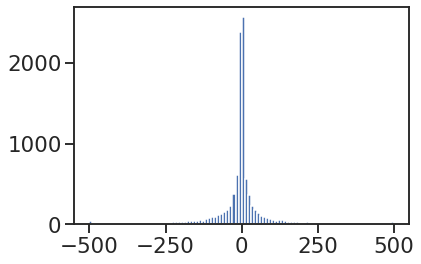

In [17]:
_ = plt.hist(res['LINEVSHIFT_BALMER'], bins=100)